In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torch.autograd import Variable


from torch.nn import Conv2d as Conv2D
import torch.nn.init as init

from torch.nn import Upsample

import cv2
import os
import csv
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload

%autoreload 2
plt.ion()   # interactive mode

In [2]:
class LungCTDataset(Dataset):
    """LungCT dataset."""

    def __init__(self, csv_file, root_dir, size=512):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.image_frame = pd.read_csv(csv_file, skiprows=1)
        self.root_dir = root_dir
        self.size=512

    def __len__(self):
        return len(self.image_frame)

    def __getitem__(self, idx):
        size = self.size
        img_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 0])
        mask_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 1])
        
        image = cv2.imread(img_name, 0)/255.
        image.resize(size, size)
        image = image.reshape((1, size, size))
        mask = cv2.imread(mask_name, 0)/255.
        mask.resize(size, size)
        mask = mask.reshape((1, size, size))
        sample = {'image': image, 'mask': mask}
        return sample
    

In [3]:
class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            Conv2D(channel_in, channel_out, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )

        
        
    def forward(self, x1, x2):
        # Input size - Batch_Size X Channel X Height of Activation Map  X Width of Activation Map
        # Upsample using bilinear mode and scale it to twice its size
        x1 = self.upsample(x1)
        # in 4D array - matching the last two in case of 5D it will take 
        # last three dimensions
        difference_in_X = x1.size()[2] - x2.size()[2]
        difference_in_Y = x1.size()[3] - x2.size()[3]
        # Padding it with the required value
        x2 = F.pad(x2, (difference_in_X // 2, int(difference_in_X / 2),
                        difference_in_Y // 2, int(difference_in_Y / 2)))
        # concat on channel axis
        x = torch.cat([x2, x1], dim=1)
        # Use convolution
        x = self.conv(x)
        return x

class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()
        self.conv = nn.Sequential(
            Conv2D(channel_in, channel_out, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Input size - Batch_Size X Channel X Height of Activation Map  X Width of Activation Map
        # Downsample First
        x = F.max_pool2d(x,2)
        # Use convolution
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet, self).__init__()
        self.input_conv = self.conv = nn.Sequential(
            Conv2D(channel_in, 8, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 32)
        self.up1 = Up(64, 16)
        self.up2 = Up(32, 8)
        self.up3 = Up(16, 4)
        self.output_conv = nn.Conv2d(4, classes, kernel_size = 1)
        
    def forward(self, x):
        
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        output = self.output_conv(x)
        return F.sigmoid(output)
    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=np.sqrt(2.0))
        init.constant(m.bias, 0.1)
    

In [4]:
# Prepare the Dataset
IMAGE_DIR = "Dataset/2d_images/"
MASK_DIR = "Dataset/2d_masks/"
with open('Dataset/Lung_CT_Dataset.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["filename", "mask"])
    for p in os.listdir(IMAGE_DIR):
        image_path = os.path.join(IMAGE_DIR, p)
        mask_path = os.path.join(MASK_DIR, p)
        writer.writerow([image_path, mask_path])


In [5]:
torch.cuda.is_available()

True

In [6]:
data = pd.read_csv("Dataset/Lung_CT_Dataset.csv")
data = data.iloc[np.random.permutation(len(data))]
p = int(len(data)*0.7)
train, validation = data[:p], data[p:]
train.to_csv("Dataset/Lung_CT_Train.csv", index=False)
validation.to_csv("Dataset/Lung_CT_Validation.csv", index=False)

In [7]:
lung_ct_train_dataset = LungCTDataset(csv_file='Dataset/Lung_CT_Train.csv', root_dir='./')
lung_ct_val_dataset = LungCTDataset(csv_file='Dataset/Lung_CT_Validation.csv', root_dir='./')
train_dataloader = DataLoader(lung_ct_train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_dataloader = DataLoader(lung_ct_val_dataset, batch_size=8, shuffle=True, num_workers=4)

In [8]:
#optimizer = optim.Adam(model_instance.parameters(), lr=0.000001)

criterion = nn.BCELoss()

In [9]:
def IoU(y_true, y_pred):
    intersection = (y_pred*y_true).sum()
    #print("int: ", intersection)
    union = y_pred.sum() + y_true.sum() - intersection
    #print("union: ", union)
    return intersection/union



def Accuracy(target, output, threshold = 0.5):
    output = output.cpu().detach().numpy()>0.6
    target = target.cpu().numpy()
    output = 1.*output.reshape(-1)
    target = 1.*target.reshape(-1)
    #print(accuracy_score(target, output))
    return(accuracy_score(target, output))

In [10]:
def train(model, epoch, optimizer):
    model.train()
    for batch_idx, data in enumerate(train_dataloader):
        data, target = Variable(data["image"]).cuda() , Variable(data["mask"]).cuda()
        
        optimizer.zero_grad()
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()), end='\r')
    print()
    return loss.detach().cpu()

In [11]:
def test(model):
    model.eval()
    test_loss = 0
    iou_metrics = 0
    acc_metrics = 0
    counter = 0
    for data in val_dataloader:
        counter +=1
        data, target = Variable(data["image"], volatile=True).cuda(), Variable(data["mask"]).cuda()
        output = model(data.float())
        test_loss += criterion(output.float(), target.float()).item() # sum up batch loss
        iou = IoU((output>0.6)*1., target*1.).cpu().item()
        iou_metrics += iou
        acc_metrics += Accuracy(target, output)
        #print("batch acc: ", Accuracy(target, output))
        #print("Accumulated: ", acc_metrics)
    #print("length is ", len(val_dataloader.dataset))
    test_loss /= counter
    
    iou_metrics /= counter
    acc_metrics /= counter
    print("Average Loss: ", test_loss)
    #print("IoU: ", iou_metrics)
    print("Accuracy: ", acc_metrics)
    return(test_loss, acc_metrics, iou_metrics)

In [12]:
model_instance = UNet(1, 1)
model_instance.cuda()

UNet(
  (input_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (down1): Down(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down2): Down(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (down3): Down(
    (conv): Sequential(
      (0): Conv2d(32

In [13]:
# 99 % validation accuracy 
train_losses = []
val_losses = []
val_iou = []
val_metrics = []
for epoch in range(1,50):
    if epoch < 10:
        lr = 1e-2
    elif epoch < 20:
        lr = 1e-3
    elif epoch < 30:
        lr = 1e-4
    else:
        lr = 1e-5
    optimizer = optim.Adam(model_instance.parameters(), lr)
    loss = train(model_instance, epoch, optimizer)
    train_losses.append(loss)
    test_loss, acc, iou = test(model_instance)
    val_losses.append(test_loss)
    val_iou.append(iou)
    val_metrics.append(acc)

Train Epoch: 1 [23/185 (96%)]	Loss: 0.3915246
Average Loss:  1.010062611103058
Accuracy:  0.7701126575469971
Train Epoch: 2 [23/185 (96%)]	Loss: 0.2350468
Average Loss:  0.5310961991548538
Accuracy:  0.6399086475372314
Train Epoch: 3 [23/185 (96%)]	Loss: 0.2442464
Average Loss:  0.9988746881484986
Accuracy:  0.7700880527496338
Train Epoch: 4 [23/185 (96%)]	Loss: 0.1858237
Average Loss:  0.6637636363506317
Accuracy:  0.6589265823364258
Train Epoch: 5 [23/185 (96%)]	Loss: 0.0924329
Average Loss:  0.9080046057701111
Accuracy:  0.6185991287231445
Train Epoch: 6 [23/185 (96%)]	Loss: 0.2352694
Average Loss:  1.9258624911308289
Accuracy:  0.7303432941436767
Train Epoch: 7 [23/185 (96%)]	Loss: 0.1758252
Average Loss:  2.402799868583679
Accuracy:  0.7700774192810058
Train Epoch: 8 [23/185 (96%)]	Loss: 0.3430462
Average Loss:  3.109277057647705
Accuracy:  0.7618229389190674
Train Epoch: 9 [23/185 (96%)]	Loss: 1.0367335
Average Loss:  0.6342700332403183
Accuracy:  0.8342462539672851
Train Epoch: 

In [14]:
unet_non_convex_report = {"train_losses": train_losses, 
                   "val_losses": val_losses,
                   "val_iou": val_iou,
                   "val_metrics": val_metrics}

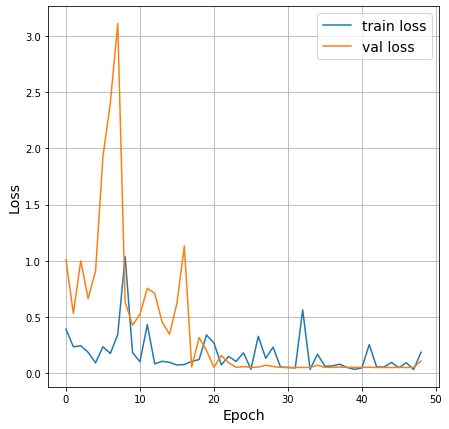

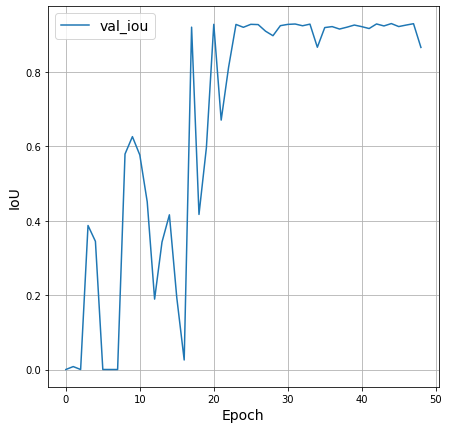

In [15]:
plt.figure(figsize=(7,7))
plt.grid()

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

plt.figure(figsize=(7,7))
plt.grid()

plt.plot(val_iou, label="val_iou")

plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("IoU", fontsize=14)
plt.show()

# Convex UNet

In [16]:
class Up_pos(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up_pos, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            Conv2D(channel_in, channel_out, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
    def positivate(self):
        #self.upsample.weight.data = F.relu(self.upsample.weight.data)
        self.conv[0].weight.data = F.relu(self.conv[0].weight.data)
        
        
    def forward(self, x1, x2):
        # Input size - Batch_Size X Channel X Height of Activation Map  X Width of Activation Map
        # Upsample using bilinear mode and scale it to twice its size
        x1 = self.upsample(x1)
        # in 4D array - matching the last two in case of 5D it will take 
        # last three dimensions
        difference_in_X = x1.size()[2] - x2.size()[2]
        difference_in_Y = x1.size()[3] - x2.size()[3]
        # Padding it with the required value
        x2 = F.pad(x2, (difference_in_X // 2, int(difference_in_X / 2),
                        difference_in_Y // 2, int(difference_in_Y / 2)))
        # concat on channel axis
        x = torch.cat([x2, x1], dim=1)
        # Use convolution
        x = self.conv(x)
        return x

class Down_pos(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down_pos, self).__init__()
        self.conv = nn.Sequential(
            Conv2D(channel_in, channel_out, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
    def positivate(self):
        self.conv[0].weight.data = F.relu(self.conv[0].weight.data)
    
    def forward(self, x):
        # Input size - Batch_Size X Channel X Height of Activation Map  X Width of Activation Map
        # Downsample First
        x = F.max_pool2d(x,2)
        # Use convolution
        x = self.conv(x)
        return x

class UNet_pos(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet_pos, self).__init__()
        self.input_conv = self.conv = nn.Sequential(
            Conv2D(channel_in, 8, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        self.down1 = Down_pos(8, 16)
        self.down2 = Down_pos(16, 32)
        self.down3 = Down_pos(32, 32)
        self.up1 = Up_pos(64, 16)
        self.up2 = Up_pos(32, 8)
        self.up3 = Up_pos(16, 4)
        self.output_conv = nn.Conv2d(4, classes, kernel_size = 1)
        
    def positivate(self):
        self.input_conv[0].weight.data = F.relu(self.input_conv[0].weight.data)
        self.down1.positivate()
        self.down2.positivate()
        self.down3.positivate()
        self.up1.positivate()
        self.up2.positivate()
        self.up3.positivate()
        self.output_conv.weight.data = F.relu(self.output_conv.weight.data)
        
    def forward(self, x):
        
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        output = self.output_conv(x)
        return F.sigmoid(output)
    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=np.sqrt(2.0))
        init.constant(m.bias, 0.1)
    

In [17]:
def train_pos(model, epoch, optimizer):
    model.train()

    for batch_idx, data in enumerate(train_dataloader):
        data, target = Variable(data["image"]).cuda() , Variable(data["mask"]).cuda()
        
        optimizer.zero_grad()
        
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.positivate()
        
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()), end='\r')
    print()
    return loss.detach().cpu()

In [18]:
pos = UNet_pos(1,1)
pos.cuda()
pos.positivate()

In [19]:
# 99 % validation accuracy 
train_losses = []
val_losses = []
val_iou = []
val_metrics = []
for epoch in range(1,50):
    if epoch < 10:
        lr = 1e-2
    elif epoch < 20:
        lr = 1e-3
    elif epoch < 30:
        lr = 1e-4
    else:
        lr = 1e-5
    optimizer = optim.Adam(pos.parameters(), lr)
    loss = train_pos(pos, epoch, optimizer)
    train_losses.append(loss)
    test_loss, acc, iou = test(pos)
    val_losses.append(test_loss)
    val_iou.append(iou)
    val_metrics.append(acc)

Train Epoch: 1 [23/185 (96%)]	Loss: 0.4636141
Average Loss:  2.301404058933258
Accuracy:  0.7061871528625489
Train Epoch: 2 [23/185 (96%)]	Loss: 0.5799670
Average Loss:  7.8544135093688965
Accuracy:  0.589916181564331
Train Epoch: 3 [23/185 (96%)]	Loss: 0.3704738
Average Loss:  6.190868902206421
Accuracy:  0.6342168807983398
Train Epoch: 4 [23/185 (96%)]	Loss: 0.6065051
Average Loss:  9.292946767807006
Accuracy:  0.5193750858306885
Train Epoch: 5 [23/185 (96%)]	Loss: 0.5587979
Average Loss:  9.757988262176514
Accuracy:  0.5127037525177002
Train Epoch: 6 [23/185 (96%)]	Loss: 0.2628324
Average Loss:  15.87191162109375
Accuracy:  0.368381929397583
Train Epoch: 7 [23/185 (96%)]	Loss: 0.2634600
Average Loss:  11.215677261352539
Accuracy:  0.5036365032196045
Train Epoch: 8 [23/185 (96%)]	Loss: 0.1684062
Average Loss:  11.221115207672119
Accuracy:  0.48889942169189454
Train Epoch: 9 [23/185 (96%)]	Loss: 0.1832645
Average Loss:  3.469561982154846
Accuracy:  0.6827409744262696
Train Epoch: 10 [

In [20]:
unet_convex_report = {"train_losses": train_losses, 
                   "val_losses": val_losses,
                   "val_iou": val_iou,
                   "val_metrics": val_metrics}

In [21]:
final_report = {"non_convex": unet_non_convex_report,
                "convex": unet_convex_report}

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.show()

plt.figure(figsize=(7,7))
plt.grid()

plt.plot(val_iou, label="val_iou")

plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("IoU", fontsize=14)
plt.show()

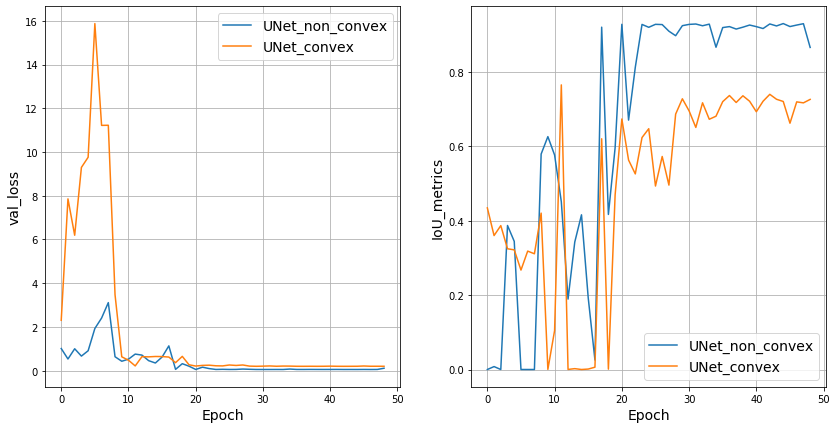

In [35]:
plt.figure(figsize=(14,7))

plt.subplot(1, 2, 1)

plt.grid()
for model in final_report.keys():
    plt.plot(final_report[model]['val_losses'], label="UNet_"+model)
plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("val_loss", fontsize=14)


plt.subplot(1, 2, 2)
plt.grid()
for model in final_report.keys():
    plt.plot(final_report[model]['val_iou'], label="UNet_"+model)
plt.legend(fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("IoU_metrics", fontsize=14)

plt.show()

In [30]:
for model in final_report.keys():
    print(final_report[model].keys())
    print()

dict_keys(['train_losses', 'val_losses', 'val_iou', 'val_metrics'])

dict_keys(['train_losses', 'val_losses', 'val_iou', 'val_metrics'])

